# Исследование данных о российском кинопрокате

## Цель

Целью исследования является выявление особенностей фильмов с государственным финансированием на общем фоне кинопроизведений в российском прокате.

## Задачи

- Изучить динамику выходов фильмов в прокат по годам,
- изучить влияние возрастных ограничений на кассовые сборы,
- изучить закономерности в фильмах с госфинансированием.

## Описание данных
Таблица `mkrf_movies` содержит информацию из реестра прокатных удостоверений. У одного фильма может быть несколько прокатных удостоверений.
- `title` — название фильма;
- `puNumber` — номер прокатного удостоверения;
- `show_start_date` — дата премьеры фильма;
- `type` — тип фильма;
- `film_studio` — студия-производитель;
- `production_country` — страна-производитель;
- `director` — режиссёр;
- `producer` — продюсер;
- `age_restriction` — возрастная категория;
- `refundable_support` — объём возвратных средств государственной поддержки;
- `nonrefundable_support` — объём невозвратных средств государственной поддержки;
- `financing_source` — источник государственного финансирования;
- `budget — общий бюджет фильма;
- `ratings` — рейтинг фильма на КиноПоиске;
- `genres` — жанр фильма.

Таблица `mkrf_shows` содержит сведения о показах фильмов в российских кинотеатрах.
- `puNumber` — номер прокатного удостоверения;
- `box_office` — сборы в рублях.

## Загрузка данных и объедините их в один датафрейм 

In [1]:
import sys
from distutils.version import StrictVersion

if StrictVersion(sys.version.split()[0]) < StrictVersion('3.8.0'):
    !pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 2.8 MB/s eta 0:00:01


In [2]:
from datetime import datetime
from functools import reduce

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", 50)

In [4]:
sns.set_style("whitegrid")

In [5]:
plt.rcParams["figure.figsize"] = (12, 8)

In [6]:
try:
    df_movies = pd.read_csv("mkrf_movies.csv")
except FileNotFoundError:
    df_movies = pd.read_csv("/datasets/mkrf_movies.csv")

In [7]:
df_movies.head(10)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама"
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный"
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
5,Остановился поезд,111013816,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.7,драма
6,Любовь и голуби,111007013,2013-10-18T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.3,"мелодрама,комедия"
7,Любовь и сигареты,221074614,2014-12-29T12:00:00.000Z,Художественный,"Юнайтед Артистс, Грин Стрит Филмз, Айкон Интер...",США,Джон Туртурро,"Джон Пенотти, Джон Туртурро",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.6,"мюзикл,мелодрама,комедия"
8,Отпетые мошенники.,121011416,2016-05-05T12:00:00.000Z,Художественный,"Пульсар Продюксьон, ТФ1 Фильм",Франция,Эрик Беснард,Патрис Леду,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,8.0,"комедия,криминал"
9,Отпуск за свой счет,111019114,2014-12-01T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм"", Телевидение ВНР","СССР, Венгрия",В.Титов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.8,"мелодрама,комедия"


In [8]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
title                    7486 non-null object
puNumber                 7486 non-null object
show_start_date          7486 non-null object
type                     7486 non-null object
film_studio              7468 non-null object
production_country       7484 non-null object
director                 7477 non-null object
producer                 6918 non-null object
age_restriction          7486 non-null object
refundable_support       332 non-null float64
nonrefundable_support    332 non-null float64
budget                   332 non-null float64
financing_source         332 non-null object
ratings                  6519 non-null object
genres                   6510 non-null object
dtypes: float64(3), object(12)
memory usage: 877.4+ KB


In [9]:
df_movies.isna().sum()

title                       0
puNumber                    0
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   967
genres                    976
dtype: int64

In [10]:
try:
    df_shows = pd.read_csv("mkrf_shows.csv")
except FileNotFoundError:
    df_shows = pd.read_csv("/datasets/mkrf_shows.csv")

In [11]:
df_shows.head()

,puNumber,box_office
0,111000113,2.45e+03
1,111000115,6.10e+04
2,111000116,1.53e+08
3,111000117,1.23e+07
4,111000118,1.64e+08


In [12]:
df_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
puNumber      3158 non-null int64
box_office    3158 non-null float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


In [13]:
df_shows.isna().sum()

puNumber      0
box_office    0
dtype: int64

Объединять датафреймы мы будем по общему полю `puNumber`. Объединять будем так, чтобы сохранить все записи из таблицы фильмов. Видно, что таблица фильмов существенно длинней таблицы с данными о результатах проката, так что в итоговом датафрейме будет много пропусков.

Проблема в том, что в `df_shows` это целые числа, а в  `df_movies` &mdash; строки. Приведём номера прокатных удостоверений к числовому формату. Этому препятствует пара записей:

In [14]:
df_movies[~df_movies["puNumber"].str.isdigit()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
804,Паранормальный Якутск,111004112,2012-08-24T12:00:00.000Z,Художественный,ИП Тимофеев К.П.,Россия,К.Тимофеев,NaN,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,NaN,NaN
1797,Курбан-роман. (История с жертвой),нет,2014-05-15T12:00:00.000Z,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_movies.loc[804, "puNumber"]

' 111004112'

У фильма "Паранормальный Якутск" номер прокатного удорстоверения начинается с пробела, а у "Курбан-роман" отсутствует. Единственный пропуск не сложно заполнить: информацию о фильме можно найти на сайте минестерства культуры. С обрамляющими пробелами всё еще проще. Они присутствуют во многих строковых параметрах, так что уберём их все разом

In [16]:
objects = df_movies.dtypes[df_movies.dtypes == "object"].index
for o in objects:
    df_movies[o] = df_movies[o].str.strip()

In [17]:
df_movies.loc[1797, "puNumber"] = 111009614

In [18]:
df_movies["puNumber"] = df_movies["puNumber"].astype("int")

In [19]:
df_movies = df_movies.merge(right=df_shows, how="left")

In [20]:
df_movies.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


### Вывод

Мы извлекли из файлов и слили две таблицы. Для этого нам пришлось преобразовать колонку `puNumber` в таблице фильмов в целый тип. Итоговая содержит информацию о фильмах и результатах их проката (для тех картин, что получили госфинансирование). 

## Предобработка данных

Из первоначального обзора видно, что многие колонки датафрейма имеют строковый тип, что верно не для всех параметров.

### Преобразования типов столбцов

Начнём с `show_start_date`, которая содержит дату начала проката

In [21]:
df_movies["show_start_date"] = pd.to_datetime(
    df_movies["show_start_date"], format="%Y-%m-%dT%H:%M:%S.%fZ"
)

Следующий столбец &mdash; тип фильма. Это категориальная переменная:

In [22]:
df_movies["type"].value_counts()

Художественный                5909
Анимационный                   829
Прочие                         406
Документальный                 288
Научно-популярный               53
Музыкально-развлекательный       1
Name: type, dtype: int64

In [23]:
df_movies["type"] = df_movies["type"].astype("category")

Категориальной переменной является и возрастное ограничение:

In [24]:
df_movies["age_restriction"].unique()

array(['«18+» - запрещено для детей', '«6+» - для детей старше 6 лет',
       '«12+» - для детей старше 12 лет',
       '«16+» - для детей старше 16 лет',
       '«0+» - для любой зрительской аудитории'], dtype=object)

In [25]:
age_restriction = pd.api.types.CategoricalDtype(
    categories=[
        "«0+» - для любой зрительской аудитории",
        "«6+» - для детей старше 6 лет",
        "«12+» - для детей старше 12 лет",
        "«16+» - для детей старше 16 лет",
        "«18+» - запрещено для детей",
    ],
    ordered=True,
)
df_movies["age_restriction"] = df_movies["age_restriction"].astype(age_restriction)
df_movies["age_restriction"].head()

0      «18+» - запрещено для детей
1    «6+» - для детей старше 6 лет
2      «18+» - запрещено для детей
3      «18+» - запрещено для детей
4      «18+» - запрещено для детей
Name: age_restriction, dtype: category
Categories (5, object): [«0+» - для любой зрительской аудитории < «6+» - для детей старше 6 лет < «12+» - для детей старше 12 лет < «16+» - для детей старше 16 лет < «18+» - запрещено для детей]

Источники финансирования &mdash; еще одна категориальная переменная

In [26]:
df_movies["financing_source"].unique()

array([nan, 'Министерство культуры', 'Фонд кино',
       'Министерство культуры, Фонд кино'], dtype=object)

то есть госфинансирование на производство фильмов в России выделяют "Фонд кино", Минкульт или они оба. Пропуски соответсвуют отсутствию госфинансирования, их можно заменить на "нет".

In [27]:
df_movies["financing_source"] = df_movies["financing_source"].astype("category")

`film_studio`, `production_country`, `director`, `producer` и `genres` по сути своей также являются категориальными: они образованы сущностями из конечных наборов. Но с ними имеется несколько проблем. Во-первых, признак может стсоять не только из единственного категориального объекта, но и из их комбинации ("СССР" и "США - Австралия"). А, во-вторых, эти эти объекты могут идти в разной последовательности, так что фактически одинаковое сочетание будет зада формально разныим строками.

Наиболее простым выходом было бы присвоить каждому объекту из каждого набора отдельный столбец с флагами. Так, советский фильм Бондарчука имел бы 1 в колонках "СССР" и "Бондарчук" и нули в колонках других стран и режисёров. Такой подход нивелировал бы и последовательность объектов в перечислении. Главный недостаток подобного подхода: мы бы получили очень широкую и разреженную таблицу (одних режисёров в датафрейме более 9 тысяч).

Последний признак с неправильным типом &mdash; рейтинг фильма. По смыслу это вещественное число, а не строка. Проблема в том, что некоторые из фильмов не имеют рейтинга (пропуски), а некоторые имеют рейтинг не в числовом виде от 0 до 10, а в процентном. К счастью, ттаких значений не много:

In [28]:
df_movies["ratings"].str.contains("%").sum()

29

In [29]:
df_movies[~df_movies["ratings"].isna() & df_movies["ratings"].str.contains("%")].head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
259,Прошлое,221030715,2015-07-29 12:00:00,Художественный,"20 Сенчюри Фокс де Архентина, Чемо, ЭйчБи Филм...",Аргентина - Бразилия,Эктор Бабенко,"Эктор Бабенко, Оскар Крамер, Хуго Сидмэн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,99%,"ужасы,триллер,драма",NaN
811,От винта!,114000212,2012-08-06 12:00:00,Анимационный,"ЗАО ""Продюсерский центр ""Парадиз""",Россия,О.Лопато,"Г.Нерсисян, А.Манасарян, А.Нерсесян",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,28%,"детский,приключения,комедия",1740.0
1053,Песочный человек,121029212,2012-11-29 12:00:00,Художественный,Спотлайт Медиа Продакшн,Швейцария,Питер Луизи,"Дэвид Луизи, Питер Луизи",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,97%,"ужасы,фантастика,фэнтези",NaN
1341,Сказка о добре и Вре,111008913,2013-11-15 12:00:00,Художественный,"НП ""Студия игрового кино ""Лик""",Россия,Е.Шиляева,К.Терещенко,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,99%,"триллер,драма,детектив",NaN
1805,Спираль.,111001014,2014-01-30 12:00:00,Художественный,"ООО ""Компания Питон""",Россия,А.Волгин,Е.Ковалева,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,99%,"аниме,мультфильм,ужасы",4295.0


Если попытаться сопоставить процентные рейтинги с рейтингами Кинопоиска, то обнаруживается, что они слабо коррелируют между собой (на примере первых нескольких фильмов из списка):

In [30]:
ratings = pd.DataFrame(
    {
        "title": [
            "Прошлое",
            "От винта!",
            "Песочный человек",
            "Спираль",
            "Золушка",
            "Главный",
        ],
        "ratings_percent": [99, 28, 97, 99, 64, 94],
        "ratings_kinopoisk": [6.7, 3.3, 6.6, 5.0, 7.1, 5.8],
    }
)
ratings

,title,ratings_percent,ratings_kinopoisk
0,Прошлое,99,6.7
1,От винта!,28,3.3
2,Песочный человек,97,6.6
3,Спираль,99,5.0
4,Золушка,64,7.1
5,Главный,94,5.8


In [31]:
ratings.corr()

,ratings_percent,ratings_kinopoisk
ratings_percent,1.00,0.61
ratings_kinopoisk,0.61,1.00


Коэффициент корреляции в 0,6 с тенденцией к падению &mdash; это весьма слабая корреляция. Это говорит о том, что нам не удастся линейно отобразить процентные рейтинги в шкалу Кинопоиска. Так что процентные рейтинги придётся считать пропусками.

In [32]:
df_movies.loc[
    ~df_movies["ratings"].isna() & df_movies["ratings"].str.contains("%"), "ratings"
] = np.nan

In [33]:
df_movies["ratings"] = df_movies["ratings"].astype("float")

In [34]:
df_movies["age_restriction"].value_counts()

«16+» - для детей старше 16 лет           2851
«18+» - запрещено для детей               1605
«12+» - для детей старше 12 лет           1593
«0+» - для любой зрительской аудитории     811
«6+» - для детей старше 6 лет              626
Name: age_restriction, dtype: int64

In [35]:
df_movies[~df_movies["refundable_support"].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1281,Пока еще жива,111005313,2013-10-11 12:00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,0.00e+00,2.65e+07,7.94e+07,Министерство культуры,8.1,"драма,мелодрама",3.65e+05
1448,Бесславные придурки,111003314,2014-03-28 12:00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,0.00e+00,2.60e+07,3.71e+07,Министерство культуры,NaN,NaN,2.81e+04
1498,Невидимки,111004213,2013-09-10 12:00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,0.00e+00,1.08e+08,1.76e+08,Фонд кино,5.3,"комедия,фантастика",2.00e+07
1524,БЕРЦЫ,111004314,2014-05-05 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,«16+» - для детей старше 16 лет,0.00e+00,2.80e+07,4.06e+07,Министерство культуры,4.2,драма,5.59e+04
1792,Братья Ч,111004414,2014-04-23 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",«16+» - для детей старше 16 лет,0.00e+00,2.50e+07,4.00e+07,Министерство культуры,6.4,драма,2.32e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464,Союз спасения,111022019,2019-12-26 12:00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,1.00e+08,4.00e+08,9.80e+08,Фонд кино,6.0,"история,биография,драма",7.18e+08
7466,Иван Царевич и Серый Волк 4,114005019,2019-12-20 12:00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, К.Феоктистов","С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,1.00e+08,0.00e+00,1.90e+08,Фонд кино,6.7,"мультфильм,приключения,семейный",5.01e+08
7474,Вторжение,111022519,2019-12-23 12:00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,1.00e+08,4.00e+08,9.44e+08,Фонд кино,5.7,"фантастика,боевик",NaN
7476,Я свободен,111023019,2019-12-26 12:00:00,Художественный,"АО ""ТПО ""Киностудия им. М.Горького""",Россия,И.Северов,С.Зернов,«12+» - для детей старше 12 лет,0.00e+00,3.00e+07,4.62e+07,Министерство культуры,5.9,драма,NaN


Кроме того, в названиях стран была обнаружена аномалия: 

In [36]:
df_movies.sort_values(by="production_country").head(3)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
7247,Дело Коллини,121027219,2019-09-19 12:00:00,Художественный,"Константин Филм, Глобал Скрин, Севен Пикчерз Сван",2019,Марко Кройцпайнтнер,"Мартин Московиц, Кристоф Мюллер, Марсель Хартг...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.4,"детектив,драма,криминал",NaN
6184,Девица,121018918,2018-09-13 12:00:00,Художественный,"Строфик Продакшнс Лимитед, Грит Пойнт Медиа",CША,"Дэвид Зеллнер, Нейтан Зеллнер","Роберт Кристофер Ольсон, Дэвид Зеллнер, Нейтан...",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,5.8,"драма,комедия,вестерн",1.13e+06
4878,Спящая красавица _,121010511,2011-08-11 12:00:00,Художественный,Скрин Аустралиа,Австралия,Джулия Ли,Джессика Брентналл,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,8.0,"мультфильм,мюзикл,фэнтези",NaN


Во-первых, 2019 очень странное название для страны. А, во-вторых, странно, что США стоят перед Австралией: определённо первая буква латинская

In [37]:
df_movies.loc[7247, "production_country"] = "Германия"
df_movies.loc[6184, "production_country"] = "США"

#### Выводы

Мы исправили типы параметров датафрейма на более соответсвующие их содержимомму. В процессе преобразования были заполнены пропуски в некоторых данных. В частности, в столбце "источник финансирования" пропуски были заменены на "нет" для фильмов без госфинансирования.

### Заполнение пропусков в датафрейме

Некоторые пропуски мы уже заполнили, но не все.

Есть очевидная группа пропусков с понятной интерпретацией и очевидными заполнителями: `refundable_support`, `nonrefundable_support` и `budget`. Эти столбцы хранят информацию о количестве бюджетных денег, полученных на изготовление фильма и бюджете фильма. Изначально в этих колонках, а также в колонке `financing_source` имелось по 7154 пропусков что соответсвует количеству фильмов без господдержки. Источники финансирования мы уже заполнили. Остаётся заполнить `refundable_support` и `nonrefundable_support` нулями. Это совершенно корректно, ведь бюдженых денег нет. Поскольку нас интересуют только бюджеты фильмов с господдержкой, для прочих фильмов бюджеты можно оставить незаполненными, это упростит формулы при вычислении средних и медиан на бюджетных картинах. 

In [38]:
df_movies.isna().sum()

title                       0
puNumber                    0
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   996
genres                    976
box_office               4327
dtype: int64

В двух фильмах пропущена страна производства:

In [39]:
df_movies[df_movies["production_country"].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 12:00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.2,"детский,комедия",194527.0
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN


Очевидно, что в обоих случаях страной производства является Россия

In [40]:
df_movies["production_country"] = df_movies["production_country"].fillna("Россия")

Есть пропуски и в режисёрах:

In [41]:
df_movies[df_movies["director"].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
764,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126003512,2012-12-04 12:00:00,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,44350.0
1735,Помпеи. Британский музей,126003413,2013-09-11 12:00:00,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3840,Зур концерт (Большой концерт).,217027010,2010-06-24 12:00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4052,"Ганс Сэйфуллин ""Авылым чишмэлэре. Ганс Сэйфулл...",217017310,2010-04-22 12:00:00,Художественный,"ООО ""Барс-Рекордс""",Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4298,Изге Вэли (Святой Валентин),217020610,2010-05-20 12:00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4415,Bon Jovi. The Circle Tour,126001710,2010-11-11 12:00:00,Прочие,Эншутц Интертейнмент Груп,США,NaN,Эншутц Интертейнмент Груп,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.9,"концерт,музыка",NaN
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00,Художественный,NaN,Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN
4923,Георг Фридрих Гендель. Мессия. Оратория. Корол...,126001111,2011-04-25 12:00:00,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4942,Питер Гэбриэл и New Blood Orchestra 3D,126002711,2011-11-11 12:00:00,Прочие,Омниверс Визион,Великобритания,NaN,Омниверс Визион,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,6.7,"концерт,музыка",NaN


С первого взгляда видно, что практически все из этих фильмов представляют собой записи концертов. Т.е. режисёра как такового в таких фильмах просто нет. Одновременно с заполнением пропусков в режисёрах, можно заполнить и пропускив в столбце "жанры" (значением "концерт,музыка"). Исключение составляют фильмы "Помпеи. Британский музей", он тоже снят без привычного режисёра, но жанр - "документальный". Второе исключение &mdash; мультипликационная передача "Мульт личности". У неё вполне есть режисёр: Юрий Владовский. За одно можно заполнить и студию: "Пространство идей" и продюсер Эрнст.

In [42]:
idx = list(df_movies[df_movies["director"].isna()].index)
idx.remove(4441)
df_movies.loc[idx, "director"] = "нет"

In [43]:
df_movies.loc[idx, "genres"] = "концерт,музыка"
df_movies.loc[1735, "genres"] = "документальный"
df_movies.loc[4441, "director"] = "Юрий Владовский"
df_movies.loc[4441, "film_studio"] = "Пространство идей"
df_movies.loc[4441, "producer"] = "Константин Эрнст"

Некоторое количество пропусков есть в столбце "студия":

In [44]:
df_movies[df_movies["film_studio"].isna()].head(10)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1293,Stars in Shorts,121011114,2014-06-03 12:00:00,Художественный,NaN,"США, Великобритания","Роберт Фестингер, Руперт Френд, Джей Камен, Ни...","Татьяна Келли, Роберта Мунро, Руперт Френд, До...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.3,комедия,NaN
6105,Значит любит,111013818,2018-08-10 12:00:00,Художественный,NaN,Россия,А.Краевский,Е.Щербакова,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6181,Несейка. Младшая дочь,112007018,2018-09-01 12:00:00,Документальный,NaN,Россия,В.Марин,"Д.Якунин, Ф.Абрютин, О.Филонова",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6379,Ян Антонышев,112011818,2018-11-15 12:00:00,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6380,Ян Антонышев,112011918,2018-11-15 12:00:00,Документальный,NaN,Россия,Е.Окопная,Е.Герасимов,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6399,Доживем до каникул?..,111021918,2018-11-15 12:00:00,Художественный,NaN,Россия,Я.Хальпукова (псевдоним Яна Мартынец),Я.Хальпукова (псевдоним Яна Мартынец),«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,41225.0
6485,До и После,112014418,2018-12-05 12:00:00,Документальный,NaN,Россия,А.Новокреповская,А.Новокреповская,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.9,"драма,криминал,детектив",NaN
6494,Калмыцкий геше Нгаванг Вангьял,113002018,2018-12-05 12:00:00,Научно-популярный,NaN,Россия,И.Долгина,И.Долгина,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6497,Мой папа Чингисхан,112014918,2018-12-06 12:00:00,Документальный,NaN,Россия,А.Сайфуллина,А.Сайфуллина,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6498,В плену города грёз,112014818,2018-12-06 12:00:00,Документальный,NaN,Россия,В.Витовцев,О.Мичи,«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.9,"фантастика,боевик,триллер",NaN


Обращает на себя внимание тот факт, что среди фильмов без студий присутсвует ряд картин/, где режисёр и продюсер совпадают. Это наводит на мысль об авторском кино, где киностудии как таковой нет. Для таких фильмов можно заменить пропуски на "нет"

In [45]:
df_movies.loc[
    df_movies["film_studio"].isna() & (df_movies["director"] == df_movies["producer"]),
    "film_studio",
] = "нет"

In [46]:
df_movies[df_movies["film_studio"].isna()].shape[0]

9

Осталось всего 9 фильмов. Такое количество можно заполнить и в ручном режиме, если только в широком доступе есть соответсвующие данные.

In [47]:
df_movies[df_movies["film_studio"].isna()].index

Int64Index([1293, 6105, 6181, 6379, 6380, 6498, 6638, 6639, 6722], dtype='int64')

In [48]:
df_movies.loc[
    1293, "film_studio"
] = "Biscuit Pictures,Contemptible Entertainment,Mission Filmworks"
df_movies.loc[6105, "film_studio"] = "Pravda Films"
df_movies.loc[6181, "film_studio"] = "Продюсерский центр «Молодёжные инициативы»"

Для остальных фильмов студию найти не удалось, так что заменим пропуск изаполнителем "не известно"

In [49]:
df_movies["film_studio"].fillna("не известно", inplace=True)

In [50]:
df_movies[df_movies["producer"].isna()].head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1,Особо важное задание,111013716,2016-09-13 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
5,Остановился поезд,111013816,2016-09-13 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Абдрашитов,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.7,драма,NaN
6,Любовь и голуби,111007013,2013-10-18 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,В.Меньшов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.3,"мелодрама,комедия",2700.0
9,Отпуск за свой счет,111019114,2014-12-01 12:00:00,Художественный,"Киностудия ""Мосфильм"", Телевидение ВНР","СССР, Венгрия",В.Титов,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.8,"мелодрама,комедия",NaN
11,Ответный ход,111019014,2014-12-01 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,М.Туманишвили,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.8,"боевик,драма,приключения",NaN


Большое количество пропусков продюсеров приходится на фильмы советского преиода. Оно и понятно: в то время в СССР исоцстранах понятие продюсирования отсутствовало. С другой стороны, в нынешних реалиях продюсированием старых фильмов киностудии "Мосфильм" занимается её правоприемник ФГУП "Киноконцерн "Мосфильм"

In [51]:
df_movies.loc[
    df_movies["producer"].isna() & df_movies["film_studio"].str.contains("Мосфильм"),
    "producer",
] = 'ФГУП "Киноконцерн "Мосфильм"'

Для остальных фильмов очевидной замены без дополнительных данных найти не удаётся. Можно, конечно, воспользоваться онлайн-сервисами вроде `kinopoick.cloud` и через их api запросить недостающие данные. Но эта задача выходит далеко за рамки данного курса. Так что просто заменим оставшиеся пропуски на "не известно"

In [52]:
df_movies["producer"] = df_movies["producer"].fillna("не известно")

Итогшо, нерассмотренными у нас остаются только пропуски в параметре "жанр". Найти очевидную замену по имеющимся данным не представляется возможным, заполнить руками тоже.  Можем оставить как есть или воспользоваться заполнителем "не известно". Поскольку нам предстоит проводить манипуляции над этим столбцом, лучше от `NaN` избавиться 

In [53]:
df_movies["genres"] = df_movies["genres"].fillna("не известно")

In [54]:
df_movies.isna().sum()

title                       0
puNumber                    0
show_start_date             0
type                        0
film_studio                 0
production_country          0
director                    0
producer                    0
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   996
genres                      0
box_office               4327
dtype: int64

Помимо явных пропусков, могут быть и неявные. Посмотрим на значения сборов:

In [55]:
df_movies["box_office"].describe()

count    3.16e+03
mean     7.65e+07
std      2.40e+08
min      0.00e+00
25%      8.57e+04
50%      2.33e+06
75%      2.40e+07
max      3.07e+09
Name: box_office, dtype: float64

Видно, что минимальная цена составляет 0 рублей. Как это понимать? фильм вышел в прокат, но не собрал ни одного рубля? Посмотрим внимательнее на эти картины:

In [56]:
df_movies[df_movies["box_office"] == 0]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
66,Анна Павлова,111011013,2013-12-19 12:00:00,Художественный,"совместное производство Киностудия ""Мосфильм"",...","СССР, Франция, Англия, Куба, ГДР",Эмиль Лотяну,"ФГУП ""Киноконцерн ""Мосфильм""",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,7.7,"драма,биография,музыка",0.0
237,Подранки,111007613,2013-10-18 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Н.Губенко,"ФГУП ""Киноконцерн ""Мосфильм""",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.2,драма,0.0
596,Запах вереска,111003012,2012-05-23 12:00:00,Художественный,"ООО ""Студия РИМ""",Россия,А.Магомедов,"М.Балашова, Е.Миронов",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.3,комедия,0.0
914,В тумане /По одноименной повести Василя Быкова/,121027712,2012-11-07 12:00:00,Художественный,"Ма Йа Де Фикшн, Лемминг Филм, Беларусьфильм, Д...",Германия - Нидерланды - Беларусь - Россия - Ла...,Сергей Лозница,Хайно Декерт,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.5,"драма,военный,история",0.0
932,Письмо для Момо,124002912,2012-10-25 12:00:00,Анимационный,"Кадокава Пикчерз, Продакшнз И Джи, Токио Броад...",Япония,Окиура Хироюки,"Хироюки Икеда, Митсухиса Ишикава, Кацзуя Хамана",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.4,"аниме,мультфильм,драма",0.0
933,Летние войны,124002812,2012-10-25 12:00:00,Анимационный,"Медхауз, Ниппон Телевижн Нетуорк Корпорейшн, К...",Япония,Мамору Хосода,"Такафуми Ватанабэ, Такуя Ито, Сэйдзи Окуда, Юи...",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.7,"аниме,мультфильм,фантастика",0.0
976,Гарегин Нжде,131000213,2013-04-23 12:00:00,Художественный,"Эй Джи Кей Продакшнз, Пан Армениан Медиа Групп",Армения,Грач Кешишян,Грач Кешишян,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.9,биография,0.0
1126,Марафон,111006712,2012-12-18 12:00:00,Художественный,"ООО ""Синема Арт Студио""",Россия,К.Оганесян,К.Оганесян,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,5.5,"комедия,мелодрама",0.0
1387,Экзамен для двоих /По роману Джин Ханфф Корелитц/,121014613,2013-06-11 12:00:00,Художественный,Депф оф Филд,США,Пол Вайц,"Пол Вайц, Керри Кохански, Эндрю Миано",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,5.8,"мелодрама,комедия,драма",0.0
1559,Последняя любовь мистера Моргана /По роману Фр...,121002614,2014-02-11 12:00:00,Художественный,"Камински Штим Фильм, Бавариа Пикчерз, Сенатор ...",Германия - Бельгия - США -Франция,Сандра Неттельбек,"Франк Камински, Астрид Камке, Филипп Кройцер, ...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.9,драма,0.0


Видно, что некоторые фильмы старые ("Анна Павлова", "Анжелика, маркиза ангелов"), то есть явно предназначены для телевизионного проката или авторское кино ("Марафон"), также скорее для распространения в сети. Так что возможно, если ошибки и есть, то это касается далеко не всех фильмов с нулевыми сборами. 

Впрочем, ошибки наверняка имеют место, например, согласно Кинопоиску фильм "Экзамен для двоих" собрал в России более 300 тысяч долларов. Впрочем, эти сборы могли быть сделаны и другим прокатным удостоверением, которого просто нет в нашем списке.

Заполнить эти пропуски (если они есть) не представляется возможным: по некоторым фильмам данные о кассовых сборах найти не удаётся. Что это означает? Что фильм не крутили в кинотеатрах? Или что просто данные найти не удалось? В такой ситуации придётся оставить всё как есть.

In [57]:
df_movies[df_movies["box_office"].isna() & (df_movies["financing_source"] != "нет")]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27 12:00:00,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,"ФГУП ""Киноконцерн ""Мосфильм""",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7481,Сад художника: Американский импрессионизм,126008019,2019-12-23 12:00:00,Прочие,Севен Артс Продакшнз,Великобритания,Фил Грабски,Фил Грабски,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,не известно,NaN
7482,Звериная ярость,121037819,2019-12-24 12:00:00,Художественный,"Дэниел Гродник Продакшнз, Вандерфилм Медиа Кор...",США,Ник Пауэлл,"Джефф Боулер, Дэниэл Гродник, Луильо Руис, Брэ...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,5.4,"боевик,триллер",NaN
7483,Щенячий патруль: Скорей спешим на помощь!,124010819,2019-12-28 12:00:00,Художественный,"Никелодеон Анимейшн Студиос, Спин Мастер",США - Канада,Чарльз Е.Бастьен,Дженнифер Додж,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,не известно,NaN
7484,"Машины песенки. Серия ""Испанские мотивы""",124010619,2019-12-30 12:00:00,Анимационный,"Анимаккорд Лтд., ООО Студия ""АНИМАККОРД""","Республика Кипр, Россия",А.Беляев,Д.Ловейко,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,не известно,NaN


#### Выводы

Мы заполнили пропуски в большинстве колонок датафрейма. В ряде случаев это удалось сделать посредством ручного поиска данных в интернете, в ряде случаев &mdash; из логики данных. В остальных исполльзовались заполнители. некоторые пропуски остались незаполненными, поскольку эти значения не имеют значения для задачи (бюджеты фильмов без госфинансирования) иди для ужлюства вычислений (рейтинги)

### Дубликаты в датафрейме

Проверим, есть ли в данных дубликаты. Не зависимо от того, повторяются ли фильмы, уж номера прокатных удостоверений должны быть уникальны по определению. Проверим так ли это: 

In [58]:
df_movies[df_movies[["puNumber"]].duplicated(keep=False)]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1797,Курбан-роман. (История с жертвой),111009614,2014-05-15 12:00:00,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,не известно,0.0
2078,Курбан-роман. (История с жертвой).,111009614,2014-09-02 12:00:00,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,не известно,0.0
4638,Как жениться и остаться холостым,221154310,2010-12-17 12:00:00,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.0,"мелодрама,комедия",NaN
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17 12:00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне Ф...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.6,"драма,мелодрама,история",NaN
5067,Анализируй это!,221054410,2010-05-25 12:00:00,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.4,"комедия,криминал",NaN
5068,Анализируй то!,221054410,2010-05-25 12:00:00,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.8,"комедия,криминал",NaN


Три прокатных удостоверения повторяются, это явная ошибка в выгрузке данных. 

И, что интересно, прокатному удостоверению №221154310 соответсвует два разных фильма: "Иоанна - женщина на папском престоле" и "Как жениться и остаться холостым". 

Удивительно, но факт: сайт Минкульта этот факт подтверждает. Как бы странно это не выглядело, мы имеем два фильма на одном номере прокатного удостоверения. Эти два фильма придётся сохранить (фильмы ведь реально разные), остальные дубликаты удалим:

In [59]:
df_movies.drop([2078, 5068], inplace=True)

Фильм вполне надёжно (за редкими исключениями) идентифицируется по названию, стране производства и режисёру. Проблема с режисёрами: что их список менеятся:

In [60]:
df_movies.loc[df_movies["title"] == "Город грехов"]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
4650,Город грехов,221155410,2010-12-17 12:00:00,Художественный,Дайменшн Филмз,США,"Фрэнк Миллер, Роберт Родригес","Фрэнк Миллер, Роберт Родригес",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.9,"боевик,триллер,криминал",NaN
6677,Город грехов,121000219,2019-03-02 12:00:00,Художественный,"Дименшн Филмз, Трублемейкер Студиос",США,"Фрэнк Миллер, Роберт Родригес, Квентин Тарантино","Элизабет Авеллан, Боб Вайнштейн, Харви Вайнште...",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.9,"боевик,триллер,криминал",NaN


И одного названия фильма не достаточно:

In [61]:
df_movies[df_movies["title"] == "Нет"]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
685,Нет,121004313,2013-02-21 12:00:00,Художественный,"Фабула, Партисипант Медиа, Фанни Баллонс, Кана...",Чили - Франция - США,Пабло Ларрайн,"Дэниэл Марк Дрейфус, Пабло Ларрейн, Хуан де Ди...",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.7,"драма,комедия",NaN
5889,Нет,211019118,2018-06-03 12:00:00,Художественный,Петухов Иван Александрович,Россия,И.Петухов,А.Сазонов,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.7,"драма,комедия",NaN


Чтобы уточнить произведение и избежать вариабильности по режисёрам, выделим первого ("главного") режисёра в отдельный столбец:

In [62]:
df_movies["first_director"] = df_movies["director"].str.split(",", expand=True)[0]

In [63]:
df_movies[df_movies[["title", "first_director"]].duplicated()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,first_director
3,Особо опасен,221026916,2016-06-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,Тимур Бекмамбетов
4,Особо опасен,221030815,2015-07-29 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,Тимур Бекмамбетов
41,Алекс и Эмма,221004616,2016-02-09 12:00:00,Художественный,"Эскейп Артистс, Франчайз Пикчерз, Рейнер-Грэйс...",США,Роб Райнер,"Тодд Блэк, Элан Грейсман, Джереми Левен, Роб Р...",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.4,"мелодрама,комедия",NaN,Роб Райнер
110,Гарри Поттер и орден Феникса /По роману Дж.К.Р...,121026316,2016-09-23 12:00:00,Художественный,"Уорнер Бразерс, Хэйдей Филмз",США - Великобритания,Дэвид Йетс,"Дэйвид Баррон, Дэйвид Хейман",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.7,"фэнтези,приключения,семейный",7.60e+05,Дэвид Йетс
113,Гарри Поттер и узник Азкабана /По роману Дж.К....,121026116,2016-09-23 12:00:00,Художественный,"Хэйдей Филмз, 1492 Пикчерз, Уорнер Бразерс",США,Альфонсо Куарон,Майкл Барната,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.2,"фэнтези,приключения,семейный",1.13e+06,Альфонсо Куарон
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7265,Альдабра: Путешествие по таинственному острову,126003719,2019-09-30 12:00:00,Прочие,Старлайт Пикчерз,Чехия,Стив Лихтаг,"Петр Келлер, Роберт Шнайдер, Леопольдо Гоут",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.8,"семейный,приключения,документальный",NaN,Стив Лихтаг
7280,Матрица,121028619,2019-10-05 12:00:00,Художественный,"Уорнер Бразерс, Вилладж Роадшоу Пикчерз, Грушо...",США,"Ларри Вачовски, Энди Вачовски",Джоэл Сильвер,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,8.5,"фантастика,боевик",NaN,Ларри Вачовски
7301,Ночь живых мертвецов,121029119,2019-10-30 12:00:00,Художественный,"Имейдж Тен, Лаурель Групп, Маркет Скьяр Продакшнз",США,Джордж А.Ромеро,"Расселл Страйнер, Карл Хардмен",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.3,"ужасы,триллер",NaN,Джордж А.Ромеро
7313,Безумный Макс: Дорога ярости,121030019,2019-12-06 12:00:00,Художественный,Уорнер Бразерс Пикчерс,"Австралия, США",Джордж Миллер,"Джордж Миллер, Даг Митчелл, Брюс Берман",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.8,"боевик,фантастика,приключения",NaN,Джордж Миллер


In [64]:
df_movies[df_movies[["title", "first_director"]].duplicated(keep=False)].shape[0]

1221

Была обнаружена 1221 проблемная запись. Очевидно, это связано с тем, что на некоторые фильмы было выдано несколько прокатных удостоверений, пример: "Аэротачки"

In [65]:
df_movies[df_movies["title"] == "Аэротачки"]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,first_director
1208,Аэротачки,124002412,2012-10-05 12:00:00,Анимационный,"Ти Филмз, Ламлайт Анимейшн Студиос",США,Тони Тэнг,"Джефф Боулер, Пегги Ли, Чарли Вонг Уинг Фанг",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.1,мультфильм,9530.0,Тони Тэнг
1209,Аэротачки,224013814,2014-10-07 12:00:00,Анимационный,"Ти Филмз, Ламлайт Анимейшн Студиос",США,Тони Тэнг,"Джефф Боулер, Пегги Ли, Чарли Вонг Уинг Фанг",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.1,мультфильм,1230.0,Тони Тэнг


На примере этого фильма видно, что и бюджет вычисляется для каждого прокатного удостоверения отдельно. Так что просто удалить дубликаты &mdash; не лучший вариант. Возможно, самым правильным будет просуммировать кассовые сборы, ведь, не смотря на разные прокатные удостоверения, это сборы одних и те же фильмов.

In [66]:
dbl = df_movies[df_movies[["title", "first_director"]].duplicated(keep=False)]
bos = dbl.groupby(["title", "first_director"]).agg({"box_office": "sum"}).reset_index()

for _, i in bos.iterrows():
    df_movies.loc[
        (df_movies["title"] == i["title"])
        & (df_movies["first_director"] == i["first_director"]),
        "box_office",
    ] = i["box_office"]

In [67]:
df_movies = df_movies.drop_duplicates(subset=["title", "first_director"])

#### Выводы

Мы обнаружили дубликаты фильмов, связанные с тем, что некоторые кинопроизведения получили более одного прокатного удостоверения. Для более объективного отражения успехов фильмов в прокате, мы просуммировали сборы по нескольким удостоверениям одного фильма. 

### Бюджеты фильмов и госдотации

Прежде чем начинать более глубокое исследование данных, рассмотрим такой важный параметр как бюджет кинокартины и государственное финансирование выделенное на неё. Очевидно, что даже если киностудия не выделила ни копейки собственных средств на создание фильма, бюджет не может быть меньше привлечённых государственных средств. Проверим это:

In [68]:
df_movies.loc[
    df_movies["refundable_support"] + df_movies["nonrefundable_support"]
    > df_movies["budget"]
].shape[0]

17

Интересно, что нашлось 17 фильмов, которые привлекли средств больше, чем их собственный бюджет. Интересно, как такое возможно?

In [69]:
df_movies.loc[
    df_movies["refundable_support"] + df_movies["nonrefundable_support"]
    < df_movies["budget"]
]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,first_director
1281,Пока еще жива,111005313,2013-10-11 12:00:00,Художественный,"АНО содействия развитию кинематографии ""Ангел-...",Россия,А.Атанесян,"А.Атанесян, М.Бабаханов, Р.Бутко",«16+» - для детей старше 16 лет,0.00e+00,2.65e+07,7.94e+07,Министерство культуры,8.1,"драма,мелодрама",3.65e+05,А.Атанесян
1448,Бесславные придурки,111003314,2014-03-28 12:00:00,Художественный,"ООО ""Компания ""АТК-Студио""",Россия,А.Якимчук,А.Тютрюмов,«12+» - для детей старше 12 лет,0.00e+00,2.60e+07,3.71e+07,Министерство культуры,NaN,не известно,2.81e+04,А.Якимчук
1498,Невидимки,111004213,2013-09-10 12:00:00,Художественный,"ООО ""Компания ""РЕАЛ-ДАКОТА""",Россия,"Р.Давлетьяров, С.Комаров","Р.Давлетьяров, А.Котелевский, А.Олейников",«12+» - для детей старше 12 лет,0.00e+00,1.08e+08,1.76e+08,Фонд кино,5.3,"комедия,фантастика",2.00e+07,Р.Давлетьяров
1524,БЕРЦЫ,111004314,2014-05-05 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,Е.Миндадзе (псевдоним Катя Шагалова),Л.Антонова,«16+» - для детей старше 16 лет,0.00e+00,2.80e+07,4.06e+07,Министерство культуры,4.2,драма,5.59e+04,Е.Миндадзе (псевдоним Катя Шагалова)
1792,Братья Ч,111004414,2014-04-23 12:00:00,Художественный,"ООО ""Студия ""Пассажир""",Россия,М.Угаров,"А.Миндадзе, Л.Антонова",«16+» - для детей старше 16 лет,0.00e+00,2.50e+07,4.00e+07,Министерство культуры,6.4,драма,2.32e+05,М.Угаров
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464,Союз спасения,111022019,2019-12-26 12:00:00,Художественный,"ЗАО ""Дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,1.00e+08,4.00e+08,9.80e+08,Фонд кино,6.0,"история,биография,драма",7.18e+08,А.Кравчук
7466,Иван Царевич и Серый Волк 4,114005019,2019-12-20 12:00:00,Анимационный,"ООО ""Студия анимационного кино ""Мельница""",Россия,"Д.Шмидт, К.Феоктистов","С.Сельянов, А.Боярский",«6+» - для детей старше 6 лет,1.00e+08,0.00e+00,1.90e+08,Фонд кино,6.7,"мультфильм,приключения,семейный",5.01e+08,Д.Шмидт
7474,Вторжение,111022519,2019-12-23 12:00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,1.00e+08,4.00e+08,9.44e+08,Фонд кино,5.7,"фантастика,боевик",NaN,Ф.Бондарчук
7476,Я свободен,111023019,2019-12-26 12:00:00,Художественный,"АО ""ТПО ""Киностудия им. М.Горького""",Россия,И.Северов,С.Зернов,«12+» - для детей старше 12 лет,0.00e+00,3.00e+07,4.62e+07,Министерство культуры,5.9,драма,NaN,И.Северов


Видно, что у всех этих фильмов бюджет нулевой. Очевидно, это ошибка. В частности, бюджет фильма "Воин" (по Кинопоиску) составил 115 млн. рублей. Фильмов не так много и можно попытаться заполнить хотя бы часть пропусков в ручном режиме: 

In [70]:
df_movies.loc[2053, "budget"] = 37_000_000
df_movies.loc[2058, "budget"] = 140_000_000
df_movies.loc[2472, "budget"] = 115_000_000
df_movies.loc[2532, "budget"] = 60_000_000
df_movies.loc[2615, "budget"] = 1_000_000_000
df_movies.loc[2788, "budget"] = 104_000_000
df_movies.loc[2874, "budget"] = 96_000_000
df_movies.loc[3047, "budget"] = 126_000_000
df_movies.loc[3565, "budget"] = 380_000_000
df_movies.loc[3739, "budget"] = 70_000_000
df_movies.loc[5673, "budget"] = 148_000_000
df_movies.loc[5806, "budget"] = 110_000_000
df_movies.loc[6008, "budget"] = 116_000_000
df_movies.loc[6323, "budget"] = 360_000_000

In [71]:
df_movies.loc[
    df_movies["refundable_support"] + df_movies["nonrefundable_support"]
    > df_movies["budget"]
]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,first_director
2684,Тряпичный союз,111010215,2015-06-08 12:00:00,Художественный,"ООО ""Кинокомпания ""КОКТЕБЕЛЬ""",Россия,М.Местецкий,"Р.Борисевич, А.Кушаев",«18+» - запрещено для детей,0.00e+00,5.90e+07,0.0,Фонд кино,6.3,"комедия,драма",1.96e+06,М.Местецкий
3675,Чудо-юдо,114001817,2017-06-27 12:00:00,Анимационный,"ООО ""КиноФирма""",Россия,А.Лукичев,"ООО ""КиноФирма""",«6+» - для детей старше 6 лет,2.00e+07,2.00e+07,0.0,Фонд кино,5.2,"мультфильм,фэнтези,семейный",5.51e+07,А.Лукичев
6823,Большое путешествие,114002419,2019-04-20 12:00:00,Анимационный,"ООО ""ЛИЦЕНЗИОННЫЕ БРЕНДЫ""",Россия,"Н.Лопато, В.Ровенский","ООО ""ЛИЦЕНЗИОННЫЕ БРЕНДЫ""",«6+» - для детей старше 6 лет,6.00e+07,1.20e+08,0.0,Фонд кино,6.2,"мультфильм,комедия,приключения",1.48e+08,Н.Лопато


Количество фильмов с нулевым бюджетом удаалось сократить до 3. Разрешить неопределённость с их финансовыми показателями не представляется возможным, а с учётом того, что нам предстоит вычислять долю привлечённых средств в общем бюджете, мы рискуем получить бесконечные значения, что очень некстати. От фильмов с неизвестным бюджетом придётся избавиться

In [72]:
df_movies = df_movies.drop([2684, 3675, 6823])

#### Выводы

Мы рассмотрели соотношение бюджета фильмов и полученных государственных средств и выявили некоторое количество фильмов с нулевыми бюджетами. Благодаря поиску по открытым источникам, удалось восстановить бюджеты большинства из фильмов. Но три картины пришлось исключить из исследования.

### Добавление новых столбцов

Мы уже добавили один дополнительный столбец, который упростил нам работу с дубликатами фильмов: `first_director`. Полезно по аналогии выденлить "главный" жанр, чтобы не работать со списками:

In [73]:
df_movies["first_genre"] = df_movies["genres"].str.split(",", expand=True)[0]

Полезным будет выделить из даты начала проката год, вместо того, чтобы каждый раз разбирать полную дату

In [74]:
df_movies["show_start_year"] = df_movies["show_start_date"].dt.year

Наконец, посчитаем, какую долю от общего бюджета фильма составляет государственная поддержка.

In [75]:
df_movies["budget_ratio"] = (
    df_movies["refundable_support"] + df_movies["nonrefundable_support"]
) / df_movies["budget"]

#### Выводы

Мы создали дополнительные столбцы, призванные упростить дальнейший анализ.

## Исследовательский анализ данных

Первый вопрос, который может встать при анализе кинопроката: сколько фильмов вышло в каждый из изучаемых годов. А поскольку нас интересую в первую очередь фильмы с госучастием, неплохо бы  узнать какую долю эти фильмы составляли в каждый из периодов.

In [76]:
df_films_years = (
    df_movies.groupby("show_start_year")
    .agg({"puNumber": "count", "box_office": lambda x: 1 - x.isna().mean()})
    .rename(columns={"puNumber": "films", "box_office": "supported_ratio"})
)
df_films_years

,films,supported_ratio
show_start_year,,
2010,761,0.27
2011,477,0.28
2012,517,0.31
2013,590,0.35
2014,729,0.41
2015,660,0.73
2016,771,0.82
2017,499,0.72
2018,882,0.55


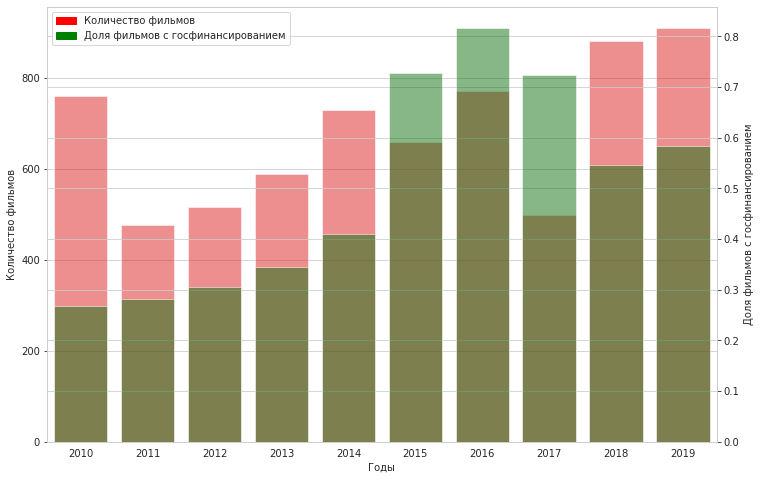

In [77]:
import matplotlib
fig, ax1 = plt.subplots()

sns.barplot(
    ax=ax1,
    data=df_films_years,
    x=df_films_years.index,
    y="films",
    alpha=0.5,
    color="red",
)
ax2 = ax1.twinx()
sns.barplot(
    ax=ax2,
    data=df_films_years,
    x=df_films_years.index,
    y="supported_ratio",
    alpha=0.5,
    #     palette='ocean'
    color="green",
)
ax1.set_ylabel("Количество фильмов")
ax2.set_ylabel("Доля фильмов с госфинансированием")
ax1.set_xlabel("Годы")

patches = [matplotlib.patches.Patch(color=i, label=t) for i,t in [('red',"Количество фильмов"),('green',"Доля фильмов с госфинансированием")]];
plt.legend(handles=patches, loc="upper left") ;

На графике видно, что пик выпуска фильмов в прокат пришёлся на 2018-2019 годы, при этом максимальная доля фильмов с госфинансированием приходится на 2015-2017 годы с тенденцией восстаноывления в 2018-2019. Несколько чужеродно смотрится всплеск фильмов в 2010 году. 

In [78]:
df_box_office_years = df_movies.groupby("show_start_year").agg({"box_office": "sum"})
df_box_office_years

,box_office
show_start_year,
2010,2.46e+06
2011,1.40e+07
2012,6.53e+06
2013,2.98e+07
2014,7.37e+09
2015,3.56e+10
2016,5.18e+10
2017,4.85e+10
2018,4.97e+10


В силу очень большой разницы в в сборах по годам (4 порядка), график есть смысл строить в логарифмическом масштабе

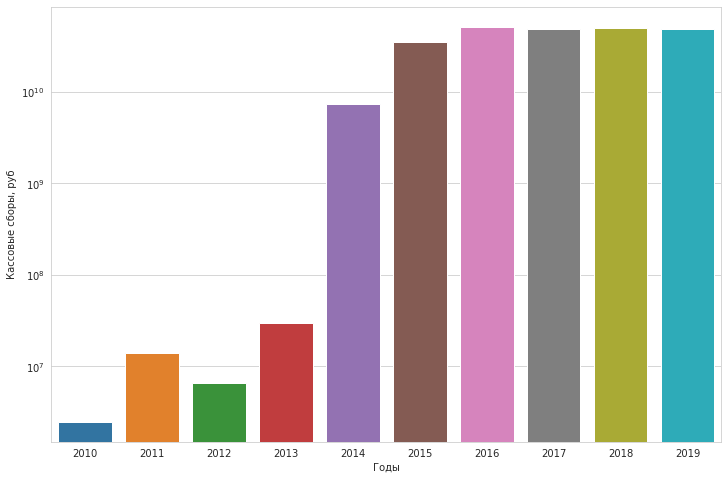

In [79]:
ax = sns.barplot(x=df_box_office_years.index, y=df_box_office_years["box_office"])
ax.set_yscale("log")
ax.set_xlabel("Годы")
ax.set_ylabel("Кассовые сборы, руб");

Видно, что наименьшие кассовые сборы приходятся на 2010 год (видимо в этот год был всплеск телевизионных премьер или очень неинтересных фильмов, которые принесли мало денег), тогда как максимум &mdash; на 2016 год (хоть по логарифмическому графику это не очень заметно).

Расчитаем среднюю и медиану кассовых сборов по годам:

In [80]:
df_movies.pivot_table(
    index="show_start_year", values="box_office", aggfunc=["mean", "median"]
)

,mean,median
,box_office,box_office
show_start_year,,
2010,1.21e+04,0.00e+00
2011,1.04e+05,1.50e+03
2012,4.13e+04,1.55e+03
2013,1.46e+05,2.45e+03
2014,2.47e+07,1.32e+04
2015,7.42e+07,3.82e+06
2016,8.23e+07,2.35e+06
2017,1.34e+08,9.70e+06


Видно, что на протяжении всех лет медиана во много раз меньше среднего, что указывает на большие выбросы вверх. Очевидно, это указвает, что большой массы фильмов с небольшим государственным участием, попадаются картины, привлекающие значительные объемы бюджетных денег. Это можно проиллюстрировать. 

Перед этим создадим новую колонку, которая будет содержать полный объём господдержки.

In [81]:
df_movies["full_support"] = (
    df_movies["nonrefundable_support"] + df_movies["refundable_support"]
)

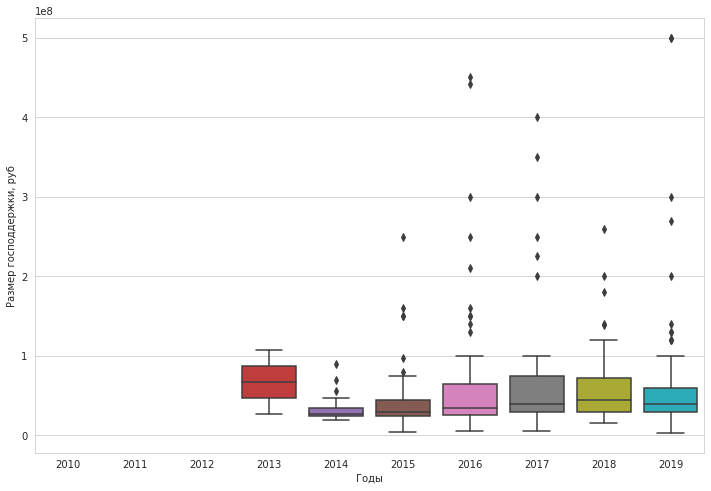

In [82]:
ax = sns.boxplot(
    data=df_movies[df_movies["financing_source"] != "нет"],
    x="show_start_year",
    y="full_support",
)
ax.set_xlabel("Годы")
ax.set_ylabel("Размер господдержки, руб");

Видно, что значительное количество госдотаций невелико и прижимается к оси абсцисс. С другой стороныс каждым годом поднимается всё выше планка крупных, пусть и не многочисленных, вложений.

Посмотрим, как влияет возрастная категория фильма на его популярность:

In [83]:
df_movies.groupby(["show_start_year", "age_restriction"]).agg(
    {"box_office": "sum"}
).reset_index()

,show_start_year,age_restriction,box_office
0,2010,«0+» - для любой зрительской аудитории,1.94e+06
1,2010,«6+» - для детей старше 6 лет,NaN
2,2010,«12+» - для детей старше 12 лет,1.03e+05
3,2010,«16+» - для детей старше 16 лет,3.62e+05
4,2010,«18+» - запрещено для детей,5.39e+04
5,2011,«0+» - для любой зрительской аудитории,1.34e+07
6,2011,«6+» - для детей старше 6 лет,NaN
7,2011,«12+» - для детей старше 12 лет,2.18e+05
8,2011,«16+» - для детей старше 16 лет,3.56e+05
9,2011,«18+» - запрещено для детей,1.04e+03


Чтобы не связываться с искажающим восприятие влиянием логарифмического масштаба, просто разобъём графики на две области: до 2014 и после

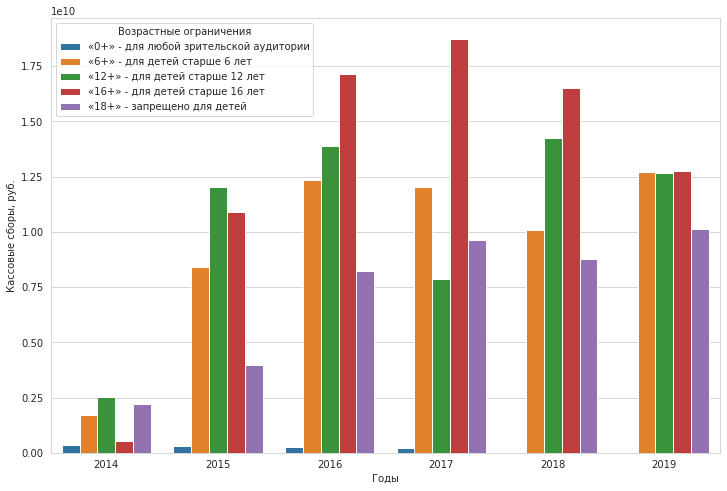

In [84]:
ax = sns.barplot(
    data=df_movies[df_movies["show_start_year"] >= 2014]
    .groupby(["show_start_year", "age_restriction"])
    .agg({"box_office": "sum"})
    .reset_index(),
    x="show_start_year",
    y="box_office",
    hue="age_restriction",
)
ax.legend(title="Возрастные ограничения")
ax.set_ylabel("Кассовые сборы, руб.")
ax.set_xlabel("Годы");

В принципе, посколькеу нас интересует прослеживание тенденций, было бы уместно использовать линейный график, но большое количество линий на одной диаграмме, кажется, сводит на нет его выразительность:

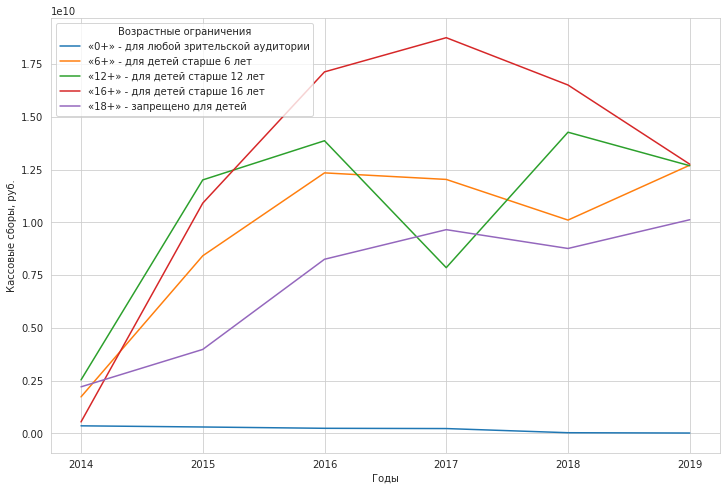

In [85]:
ax = sns.lineplot(
    data=df_movies[df_movies["show_start_year"] >= 2014]
    .groupby(["show_start_year", "age_restriction"])
    .agg({"box_office": "sum"})
    .reset_index(),
    x="show_start_year",
    y="box_office",
    hue="age_restriction",
)
ax.legend(title="Возрастные ограничения")
ax.set_ylabel("Кассовые сборы, руб.")
ax.set_xlabel("Годы");

Видно, что после 2016 года наибольшие сборы, среди картин с господдержкой, приносили фильмы категории "16+", тогда как в период 2014-2015 наиболее прибыльными были фильмы "12+". При этом доля фильмов "18+" более-менее равномерно растёт, фильмы "6+" остаются на примерно одном сравнительно высоком уровне, а доля фильмов "0+" пренебрежимо мала.

Абсолютными чемпионами по сборам стали в 2017 году фильмы категории "16+".

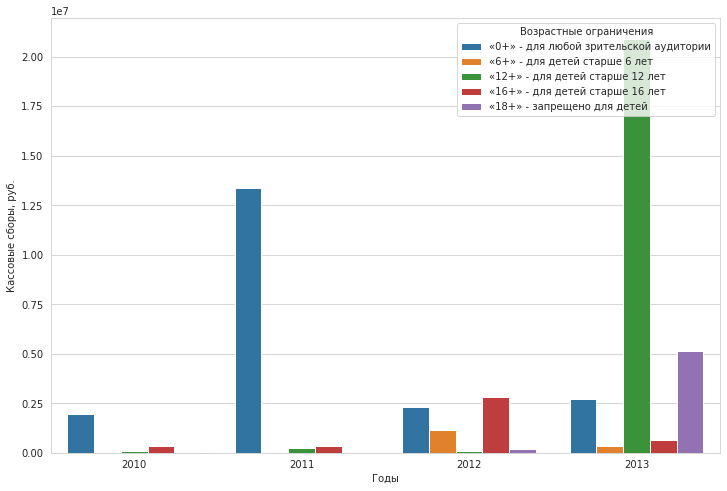

In [86]:
ax = sns.barplot(
    data=df_movies[df_movies["show_start_year"] < 2014]
    .groupby(["show_start_year", "age_restriction"])
    .agg({"box_office": "sum"})
    .reset_index(),
    x="show_start_year",
    y="box_office",
    hue="age_restriction",
)
ax.legend(title="Возрастные ограничения")
ax.set_ylabel("Кассовые сборы, руб.")
ax.set_xlabel("Годы");

Видно, что в начале 2010-х фильмы делали удивительно маленькие кассовые сборы. Очевидно, это связано и с малым количеством фильмов и малыми бюджетами, так что фильмы некоторых возрастных  категорий не получили поддержки вовсе. Удивительный факт: в 2010-2011 годах львиная доля сборов пришлась на картины "0+".

В 2013 резко подскочили фильмы "12+", продолжившие рост в последующие 3 года.

Можно предположить, что рост кассовых сборов связан в том числе и с возрождением российского кинематографа. Подсчитаем количество российских фильмов по годам  

In [87]:
df_movies["is_russia"] = np.where(
    df_movies["production_country"].str.contains("Россия"), 1, 0
)

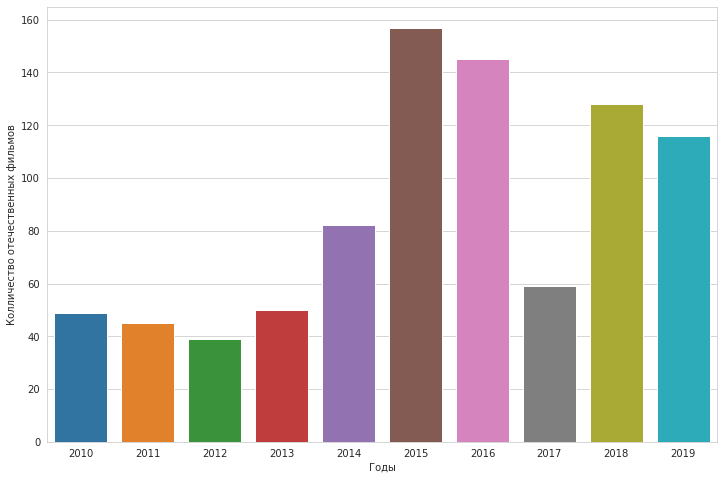

In [88]:
ax = sns.barplot(
    data=df_movies[~df_movies["box_office"].isna()]
    .groupby("show_start_year")
    .agg({"is_russia": "sum"})
    .reset_index(),
    x="show_start_year",
    y="is_russia",
)
ax.set_xlabel("Годы")
ax.set_ylabel("Колличество отечественных фильмов");

Графики не идеально совпадают, но заметный рост количества фильмов в 2014-2015 годам прослеживается.  Интересно, что пик и последющее значителдьное падение на графике количества российских фильмов пох на аналогичный на графике доли фильмов с госучастием только со смещением на год: больше всего российских фильмов было выпущено в прокат в 2015, тогда как пик участия государства в кинопроизводстве приходится на 2016 год

### Выводы

Мы исследовали кинопрокат по годам. 
- Количество фильмов в прокате расло год от года между 2011 и 2019 почти равномерно, если не считать небольшой просадки в 2015 и весьма значительной в 2017 годах. 
- доля фильмов с госфинансированием росла ещё быстрее вплоть до 2016, потом резко просела в 2018, но в следующем году снова пошла в рост.
- Самыми прибыльными в период 2016-2019 оказались фильмы "16+" с пиком в 2017, тогда как "12+" колебались вокруг некоторого среднего значенния, а "18+" равномерно растёт, начиная с 2013 года.

## Исследование фильмов, которые получили государственную поддержку

На этом этапе нет конкретных инструкций и заданий — поищите интересные закономерности в данных. Посмотрите, сколько выделяют средств на поддержку кино. Проверьте, хорошо ли окупаются такие фильмы, какой у них рейтинг.

Первый вопрос, который возникает при изучении фильмов с господдержкой: сколько вообще этой поддержки суммарно и в среднем на фильм.

Для удобства выделим фильмы с господдержкой в отдельный датафрейм

In [89]:
df_supported = df_movies[df_movies["financing_source"] != "нет"]

In [90]:
pd.options.mode.chained_assignment = None
df_supported["financing_source"] = (
    df_supported["financing_source"].astype("str").astype("category")
)

In [91]:
df_supported.pivot_table(
    index="show_start_year", values="full_support", aggfunc=["sum", "mean", "median"]
)

,sum,mean,median
,full_support,full_support,full_support
show_start_year,,,
2010,0.00e+00,NaN,NaN
2011,0.00e+00,NaN,NaN
2012,0.00e+00,NaN,NaN
2013,1.34e+08,6.72e+07,6.72e+07
2014,5.72e+08,3.58e+07,2.75e+07
2015,3.60e+09,4.23e+07,3.00e+07
2016,4.30e+09,7.05e+07,3.50e+07
2017,3.14e+09,7.86e+07,4.00e+07


Видно, что за период с 2013 до 2019 года объём вложения госсредств в кинопроизводство вырос более чем в 35 раз. При этом медианное значение даже несколько снизилось (с почти 70 до 40 млн. рублей). Ниже приведён график изменния средней господдержки с годами:

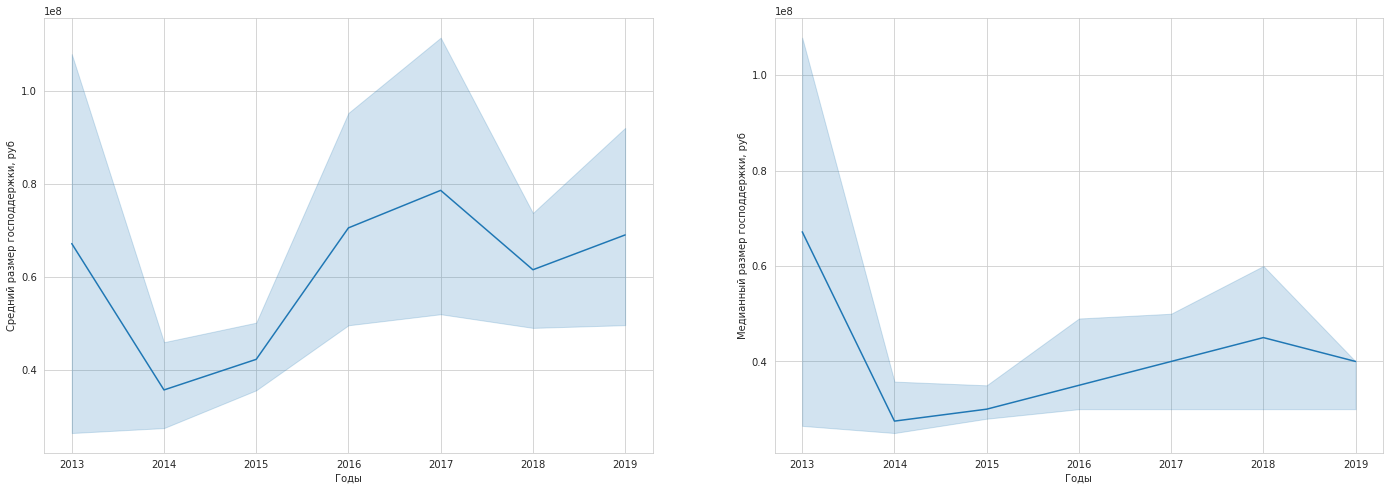

In [92]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

sns.lineplot(ax=ax1, data=df_supported, x="show_start_year", y="full_support")
ax1.set_xlabel("Годы")
ax1.set_ylabel("Средний размер господдержки, руб")

sns.lineplot(
    ax=ax2,
    data=df_supported,
    x="show_start_year",
    y="full_support",
    estimator=np.median,
)
ax2.set_xlabel("Годы")
ax2.set_ylabel("Медианный размер господдержки, руб");

График показывает, что не смотря на то, что на краях диапазонп медианная поддержка в 2010 году действительно выше, чем в 2019, но и то и другой скорее отклонение от общей тенденции: между 2014 и 2018 медиана поступательно росла.

Интересно посмотреть, какую долю государственные деньги составляют в бюджете фильмов:

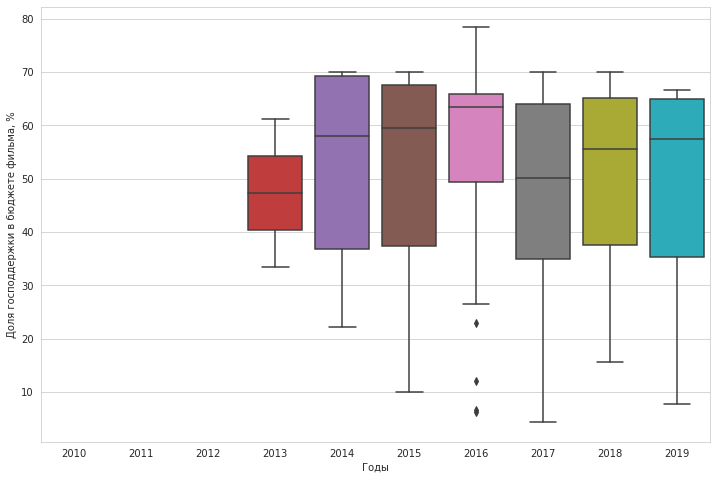

In [93]:
ax = sns.boxplot(
    x=df_supported["show_start_year"], y=df_supported["budget_ratio"] * 100
)
ax.set_xlabel("Годы")
ax.set_ylabel("Доля господдержки в бюджете фильма, %");

Видно, что медианное значение составляло менее 50% только в 2013 году и превышало 60% единожды в 2016. в остальное время оставаясь в этом диапазоне. Ещё одна особенность 2016 года &mdash; крупный верхний "ус", а равно и выброс вниз. Очевидно, этот год отличился как фильмами, сделанными в значительной степени на государственные средства (почти 80%), так и теми, картинами, что привлекли 10% госсредств и даже меньше. Очень неоднозначный год.

Интересно узнать каких жанров и типов фильмы предпочитают финансировать госфонды.

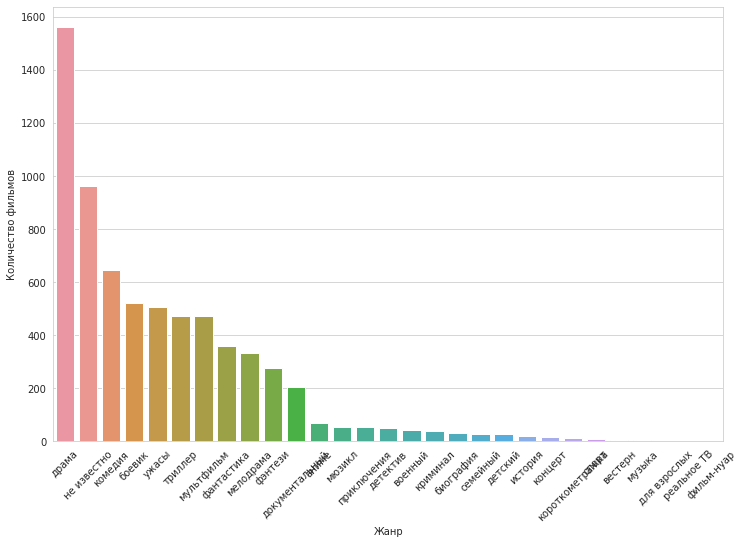

In [94]:
ax = sns.countplot(
    x=df_supported["first_genre"],
    order=df_supported["first_genre"].value_counts().index,
)
ax.set_xlabel("Жанр")
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Количество фильмов");

По жанрам с большим отрывом лидируют драма и комедия, замыкает тройку лидиров анимация

Попробуем разобраться, в фильмы каких возрастных групп вкладываются госсредства

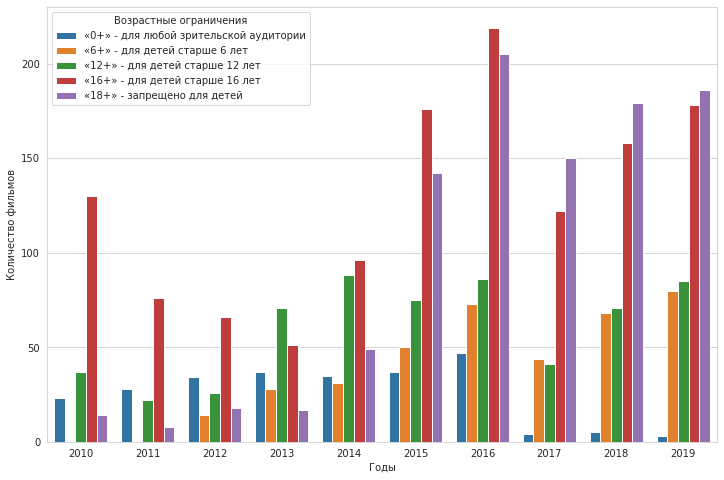

In [95]:
ax = sns.barplot(
    data=df_supported.groupby(["show_start_year", "age_restriction"])
    .agg("count")  # ({"box_office": "sum"})
    .reset_index(),
    x="show_start_year",
    y="box_office",
    hue="age_restriction",
)
ax.legend(title="Возрастные ограничения")
ax.set_ylabel("Количество фильмов")
ax.set_xlabel("Годы");

Отчётливо виден пик в категории фильмов "16+" в 2015 году с последующим спадом до минимума 2017 и последующим восстановительным ростом. Очень похожая картина и среди детских фильмов ("6+").  Пик вложений в фильмы "12+" пришёлся также на 2015-2016 годы с последующим постепенным снижением. 

А как связаны господдержка и рейтинг фильма и кассовые сборы?

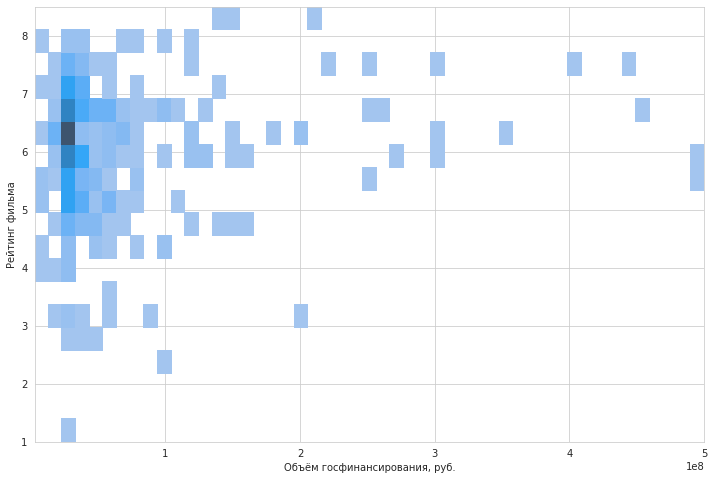

In [96]:
ax = sns.histplot(data=df_supported, x="full_support", y="ratings")
ax.set_xlabel("Объём госфинансирования, руб.")
ax.set_ylabel("Рейтинг фильма");

Видно, что основная масса фильмов получила не очень большое госфинансирование и имеет средние рейтинги в окрестностях 6,5. При этом есть заметный выброс вараво: фильмы получившие значительное финансирование из бюджета, но демонстрирующие столь же средние рейтинги. Есть и небольшой выброс вниз: фильмы вызвали у зрителей скорее негативный отклик. 

Думается, задачей на будущее для Фонда кино стоит сделать предсказание подобных картин и исключение их из списка на господдержку.

In [97]:
df_supported[df_supported["ratings"] < 4]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,first_director,first_genre,show_start_year,budget_ratio,full_support,is_russia
84,Блондинка и блондинка,221020115,2015-05-25 12:00:00,Художественный,Ригел Интертейнмент,США,Дин Хэмилтон,"Джефри Бармаш, Кирк Шоу",«16+» - для детей старше 16 лет,NaN,NaN,NaN,nan,2.4,"комедия,криминал",NaN,Дин Хэмилтон,комедия,2015,NaN,NaN,0
463,Тот еще...!,111001612,2012-02-20 12:00:00,Художественный,"ООО ""Энджой мувиз""",Россия,С.Андреасян,Г.Малков,«12+» - для детей старше 12 лет,NaN,NaN,NaN,nan,2.6,"фэнтези,комедия,семейный",1.28e+04,С.Андреасян,фэнтези,2012,NaN,NaN,1
472,901 километр,111001112,2012-02-08 12:00:00,Художественный,"ООО ""ВолгаКино""",Россия,Б.Куломзин,"А.Крутов, Л.Кашин",«16+» - для детей старше 16 лет,NaN,NaN,NaN,nan,3.8,триллер,NaN,Б.Куломзин,триллер,2012,NaN,NaN,1
514,Ржевский против Наполеона,111000212,2012-01-12 12:00:00,Художественный,"ООО ""Территория Кино""",Россия,М.Бальчунас,"ООО ""Квартал Леополис""",«16+» - для детей старше 16 лет,NaN,NaN,NaN,nan,3.0,комедия,2.00e+02,М.Бальчунас,комедия,2012,NaN,NaN,1
515,Ночь в супермаркете,124001212,2012-05-02 12:00:00,Анимационный,"Си 47 Продакшнз, Лайнс Гейт Фэмили Интертейнме...",США,Лоуренс Казанофф,"Джордж Джонсен, Лоуренс Казанофф, Элисон Сэвич...",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,nan,1.6,"мультфильм,комедия,семейный",6.20e+02,Лоуренс Казанофф,мультфильм,2012,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6911,Проклятые,121011319,2019-05-09 12:00:00,Художественный,Мидленд Интертейнмент,США,Люк Джейден,"Эли Бардха, Фред Бергер",«18+» - запрещено для детей,NaN,NaN,NaN,nan,3.7,"ужасы,триллер,драма",4.15e+06,Люк Джейден,ужасы,2019,NaN,NaN,0
6954,Игрища престолов,121013419,2019-05-23 12:00:00,Художественный,"Конгломерат Медиа, Пурже оф Тронес, Свен Груп",США,Ара Пайая,Армандо Гутьеррез,«18+» - запрещено для детей,NaN,NaN,NaN,nan,3.0,комедия,1.38e+06,Ара Пайая,комедия,2019,NaN,NaN,0
7207,Проклятие крови,121025819,2019-09-19 12:00:00,Художественный,"Ю Эф О Пикчерз, Сафьер Интертейнмент, Вэйд Тог...",США,Джеймс Каллен Брэссак,"Мика Брандт, Каллен Брэссак, Джаред Сэфьер, Дж...",«18+» - запрещено для детей,NaN,NaN,NaN,nan,3.5,"ужасы,триллер",1.35e+05,Джеймс Каллен Брэссак,ужасы,2019,NaN,NaN,0
7396,Фабрика грёз,121034319,2019-11-28 12:00:00,Художественный,"Траумфабрик Бабельсберг, Тобис Фильм, Телепул,...",Германия,Мартин Шрейер,"Кристоф Фиссер, Том Циклер",«12+» - для детей старше 12 лет,NaN,NaN,NaN,nan,3.1,ужасы,NaN,Мартин Шрейер,ужасы,2019,NaN,NaN,0


Впрочем, по списку фильмов уже видно, что госфогнды сделали каие-то выводы: в 2019 поддержку получил лишь один фильм с рейтингом 4 и ниже. в 2018 таких было 2. А осоновная масса приходится на развесёлый 2016 (когда, похоже, финансировали вообще всё подряд) и 2015 годы.

Теперь рассмотрим связ госфинансирования и кассовых сборов. Можно построить простую зависимость сборов и предоставленныз бюджетных денег, а можно рассмотреть связь с окупаемостью фильма (отношением кассовых сборов к бюджету фильма)

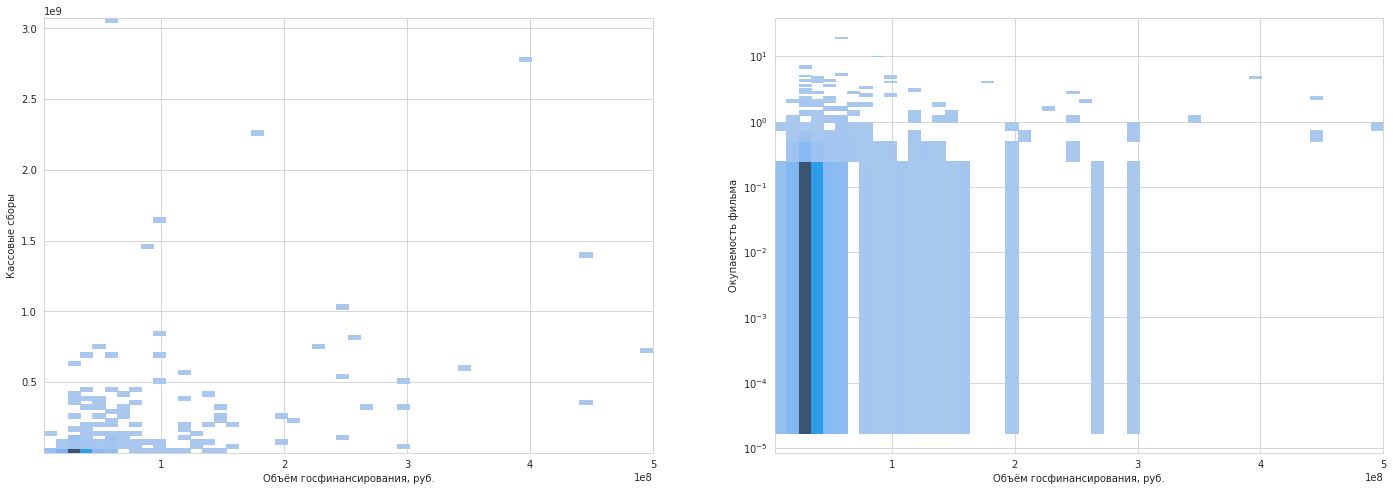

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

sns.histplot(ax=ax1, data=df_supported, x="full_support", y="box_office")
ax1.set_xlabel("Объём госфинансирования, руб.")
ax1.set_ylabel("Кассовые сборы")

sns.histplot(
    ax=ax2,
    x=df_supported["full_support"],
    y=df_supported["box_office"] / df_supported["budget"],
)
ax2.set_xlabel("Объём госфинансирования, руб.")
ax2.set_yscale("log")
ax2.set_ylabel("Окупаемость фильма");

Увы, согласно графикам, но основная часть фильмов с госфинансированием так и не окупилась. Да есть небольшое количество картин получивших сборы кратно превышающие бюджет, но их не много. Кстати, в основном такие фильмы и государственного финансирования привлекли не очень много (в районе десятков миллионов рублей). При этом имеется фильм, получивший 0,5 млрд. господдержки, но так и не окупивший свой бюджет &mdash; "Союз спасения", которйы при бюджете в 980 млн. рублей смог собрать лишь 718 млн.

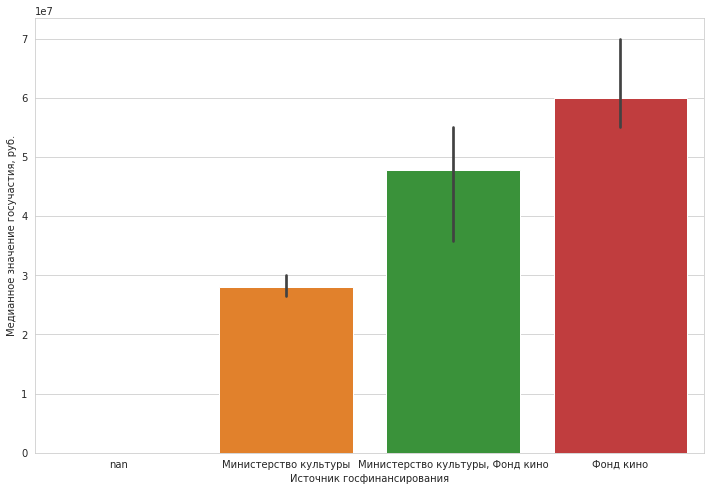

In [99]:
ax = sns.barplot(
    x=df_supported["financing_source"],
    y=df_supported["full_support"],
    estimator=np.median,
)
ax.set_xlabel("Источник госфинансирования")
ax.set_ylabel("Медианное значение госучастия, руб.");

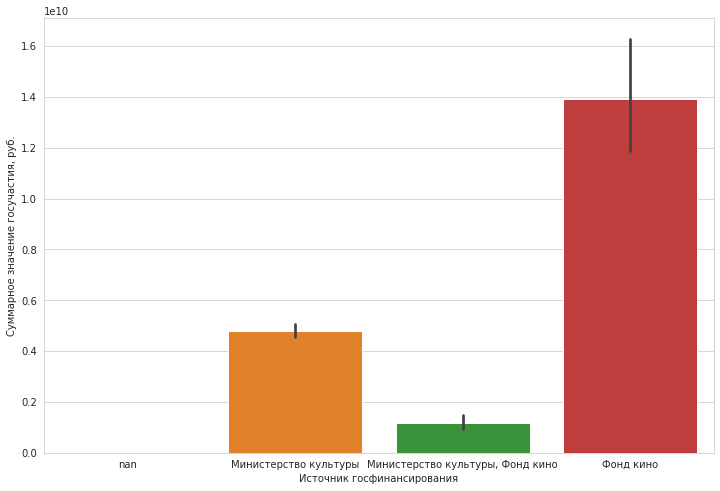

In [100]:
ax = sns.barplot(
    x=df_supported["financing_source"],
    y=df_supported["full_support"],
    estimator=np.sum,
)
ax.set_xlabel("Источник госфинансирования")
ax.set_ylabel("Суммарное значение госучастия, руб.");

Видно, что в финансировании киноиндустрии лидирует Фонд кино (что не удивительно). Он выделяет самые крупные дотации (60 млн. по медиане) и в целом за период 2013-2019 гг выделил дотаций на почти 14 млрд. рублей. Довольно крупные пакеты поддержки выделяют совместно Минкульт и фонд кино (почти 5 млн. по медиане), но количество подобных вложений невилико. 

А кто из режисёров наиболее обласкан господдержкой? К сожалению, по всем режисёрам построить график непросто: главных режисёров в нашей таблице 266 человек. В таком случае выберем фаворитов, попадающих в самую денежную четвёртую квартиль 

In [101]:
directors = df_supported.pivot_table(
    index="first_director", values="full_support", aggfunc=np.sum
).sort_values(by="full_support", ascending=False)

In [102]:
directors_4q = directors[directors["full_support"] > 6.38e07]
directors_4q.shape[0]

67

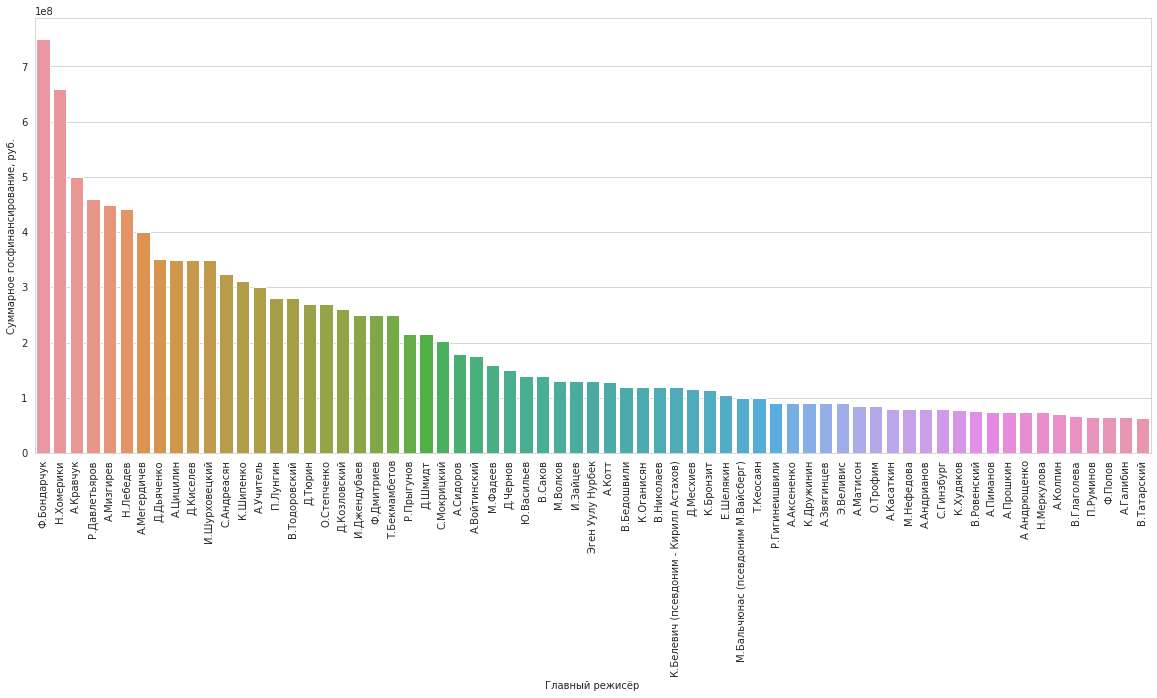

In [103]:
fig, ax = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x=directors_4q.index, y=directors_4q["full_support"], ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Главный режисёр")
ax.set_ylabel("Суммарное госфинансирование, руб.");

Подобных баловней судьбы оказалось 67 человек. Таким образом примерно 25% наиболее именитых и приближённых получают 75% финансирования. И первые две строчки пръедистала принадлежат Фёдору Бондарчуки и Николаю Хомерики. Для этого даже не нужно было проделывать сложные вычисления.

In [104]:
df_supported[
    (df_supported["first_director"] == "Ф.Бондарчук")
    | (df_supported["first_director"] == "Н.Хомерики")
].sort_values(by=["first_director", "full_support"])

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,first_director,first_genre,show_start_year,budget_ratio,full_support,is_russia
5673,Селфи,111012117,2018-02-01 12:00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Н.Хомерики,"П.Ануров, Ф.Бондарчук, Д.Рудовский",«16+» - для детей старше 16 лет,2.00e+07,4.00e+07,1.48e+08,Фонд кино,5.8,"триллер,драма",2.25e+08,Н.Хомерики,триллер,2018,0.41,6.00e+07,1
3453,Ледокол,111016316,2016-10-11 12:00:00,Художественный,"ООО ""Продюсерская фирма Игоря Толстунова""",Россия,Н.Хомерики,"И.Толстунов, С.Козлов",«12+» - для детей старше 12 лет,1.00e+08,2.00e+08,4.30e+08,Фонд кино,6.5,драма,3.37e+08,Н.Хомерики,драма,2016,0.70,3.00e+08,1
6887,Девятая,111007019,2019-09-19 12:00:00,Художественный,"ООО ""Нон-Стоп Продакшн""",Россия,Н.Хомерики,"С.Мелькумов, А.Роднянский",«16+» - для детей старше 16 лет,0.00e+00,3.00e+08,4.54e+08,Фонд кино,5.8,"детектив,триллер,криминал",5.59e+07,Н.Хомерики,детектив,2019,0.66,3.00e+08,1
4341,Черчилль.,211001210,2010-01-19 12:00:00,Художественный,"ООО ""ЧБк фильм""",Россия,"Н.Хомерики, О.Бычкова, С.Мокрицкий, С.Егерев, ...",И.Малкин,«16+» - для детей старше 16 лет,NaN,NaN,NaN,nan,7.1,"драма,биография,история",NaN,Н.Хомерики,драма,2010,NaN,NaN,1
4431,Ночь длиною в жизнь,111009910,2010-10-29 12:00:00,Художественный,"ООО ""Кинокомпания Отражение""",Россия,Н.Хомерики,"М.Бабаханов, Е.Борисова, Н.Горшкова",«16+» - для детей старше 16 лет,NaN,NaN,NaN,nan,6.9,"драма,военный",NaN,Н.Хомерики,драма,2010,NaN,NaN,1
5300,Сердца бумеранг,111009811,2011-12-16 12:00:00,Художественный,РО Фонд поддержки кинематографии для детей и ю...,Россия,Н.Хомерики,"С.Кучмаева, А.Рагозина",«18+» - запрещено для детей,NaN,NaN,NaN,nan,6.1,драма,NaN,Н.Хомерики,драма,2011,NaN,NaN,1
3565,Притяжение (2016),111018116,2016-12-16 12:00:00,Художественный,"ООО ""Водород 2011"", ООО ""Арт Пикчерс Студия""",Россия,Ф.Бондарчук,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,0.00e+00,2.50e+08,3.80e+08,Фонд кино,5.6,фантастика,1.04e+09,Ф.Бондарчук,фантастика,2016,0.66,2.50e+08,1
7474,Вторжение,111022519,2019-12-23 12:00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Водород 2011""",Россия,Ф.Бондарчук,"Ф.Бондарчук, М.Врубель, А.Андрющенко, Д.Рудовский",«12+» - для детей старше 12 лет,1.00e+08,4.00e+08,9.44e+08,Фонд кино,5.7,"фантастика,боевик",NaN,Ф.Бондарчук,фантастика,2019,0.53,5.00e+08,1
1734,Сталинград .,111004313,2013-09-20 12:00:00,Художественный,"ООО ""Арт Пикчерс Студия"", ООО ""Нон-Стоп Продакшн""",Россия,Ф.Бондарчук,"ООО ""Арт Пикчерс Студия"", ООО ""Нон-Стоп Продак...",«12+» - для детей старше 12 лет,NaN,NaN,NaN,nan,5.7,"военный,драма,боевик",2.10e+03,Ф.Бондарчук,военный,2013,NaN,NaN,1


### Вывод

- В государственном финансировании наибольшее участие принимает Фонд кино, который выделяет наибольшие дотации и в набольшем количестве.
- Среди кинематографических жанров поддержку получают в первую очередь драмы, а также комедии.
- Доля государственной поддержки (по медианному значению) за период 2013-2019 гг находилась, в основном, в интервале 50-60%.
- Объем госфинансирования слабо связан с рейтингами фильмов и большинство фильмов получают небольшое финансирования и средние рейтинги.
- Большая часть фильмов, получивших господдержку, так и не окупилась в прокате.
- 25% режисёров привлекают 75% господдержки.

## Общий вывод

- В период 2013-2019 гг количество фильмов в российском прокате росло почти непрерывно с небольшой просадкой в 2017-2018гг. При этом максимальная доля фильмов с госфинансированием приходится на 2015-2017 годы.
- После 2013 года произошёл кратный рост кассовых сборов: если в 2013 они сосавили порядка 30 млн. рублей, то после 2015 колебдлюблюдся в районе 50 млрд. рублей.
- В период 2014-20109 годы медианное значение госдотаций на создание фильма остаётся небольшим и составляет порядка 50 млн. рублей. Но на этьом фоне имеются отдельные фильмы, привлекающие много больше бюджетных средств. И эти суммы от года к году растут, достигнув в 2019 значения 500 млн. рублей
- В целом, колличество российских фильмов в кинопрокате скачкообразно возросло в 2015 году с последуюшим плавным снижением в ппоследующие годв (и резким провалом в 2017).
- Что касается возрастных категорий, то наибольший отклик у зрителей получили в период 2015-2017 фильмы "16+", в 2018-2019 интерес к ним снижается. При этом уверенно растут в популярности фильмы "18+".
- Существенной проблемой госфондов, субсидирующих кинопроизводство является то, что большинство фильмов с господдержкой не окупаются в прокате.
- Также средние рекйтинги фильмов с госфинансированием &mdash; средние и увеличение госвложений не улучшает ситуацию.